In [127]:
import numpy as np
import random
import scipy.stats as ss
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from matplotlib import style

In [128]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 150
style.use('seaborn')

# Basic threshold model

## Time to consensus

In [129]:
def extract_data(graph, opinion0_prob):
    G = nx.number_of_nodes(graph)
    nodes = list(graph.nodes())
    opinion0_count = int(opinion0_prob*G)
    opinions = [-1]*opinion0_count + [1]*(G - opinion0_count)
    random.shuffle(opinions)
    neighbors = [0]*G
    for i in range(G):
        neighbors[i] = list(graph.neighbors(nodes[i]))
    return np.array(opinions), neighbors

In [130]:
def sym_to_consensus(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    last_values = np.zeros(10000)
    data = extract_data(graph, opinion0_prob)
    opinions, neighbors = data
    len_opinions = len(opinions)
    
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        nodes = np.random.randint(0, len_opinions, size=len_opinions)
        epsilons = np.random.uniform(size=len_opinions) < epsilon
        
        for i, node in enumerate(nodes):
            opinion = opinions[node]
            chosen_neighbors = random.sample(neighbors[node], k = q)
            chosen_opinions = opinions[chosen_neighbors]
            opposite_opinion = np.count_nonzero(chosen_opinions==-1*opinion)

            if opposite_opinion >= q0: 
                opinions[node] *= -1
            elif (epsilons[i] and opposite_opinion > 0):
                opinions[node] *= -1
                
        step += 1
        
    return step

In [131]:
def monte_carlo_sym_random(n, graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(n, graph_prob)
        steps = sym_to_consensus(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [132]:
def monte_carlo_sym_watts(n, watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        steps += sym_to_consensus(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [133]:
def monte_carlo_sym_barabasi(n, barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.barabasi_albert_graph(n, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        steps = sym_to_consensus(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                print((0, i))
                return 0
    return mean_step / MC_steps

In [134]:
def consensus_time_random(ns, graph_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**4):
    mean_times = np.zeros(len(ns))
    for n in range(len(ns)):
        mean_times[n] = monte_carlo_sym_random(ns[n], graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
        if mean_times[n] == 0:
            break
    return mean_times

In [135]:
def consensus_time_barabasi(ns, barabasi_edges, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**4):
    mean_times = np.zeros(len(ns))
    for n in range(len(ns)):
        mean_times[n] = monte_carlo_sym_barabasi(ns[n], barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
        if mean_times[n] == 0:
            break
    return mean_times

In [136]:
def consensus_time_watts(ns, watts_edges, watts_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**4):
    mean_times = np.zeros(len(ns))
    for n in range(len(ns)):
        mean_times[n] = monte_carlo_sym_watts(ns[n], watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
        if mean_times[n] == 0:
            break
    return mean_times

### Barabasi

In [ ]:
ns = np.arange(100, 2000, 200)
epsilons = np.arange(0.1, 0.5, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5
barabasi_edges = 8

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_barabasi(ns, barabasi_edges, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**4))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv(f'data/Barabasi_{q}_{q0}.csv')

In [ ]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)
plt.title('Time to consensus as function of network size for BA(N, 8)')
plt.xlabel('N')
plt.ylabel('MCS')
plt.savefig(f'plots/Barabasi_consensus_{q}_{q0}.png')

### Watts

In [ ]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
watts_edges, watts_prob = 12, 0.2

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_watts(ns, watts_edges, watts_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**4))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv(f'data/Watts_{q}_{q0}.csv')

In [ ]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)
plt.title('Time to consensus as function of network size for WS(N, 12, 0.2)')
plt.xlabel('N')
plt.ylabel('MCS')
plt.savefig(f'plots/Watts_consensus_{q}_{q0}.png')

### Random

In [ ]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
graph_prob = 0.12

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_random(ns, graph_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**4))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv(f'data/Random_{q}_{q0}.csv')

In [ ]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)
plt.title('Time to consensus as function of network size for RG(N, 0.12)')
plt.xlabel('N')
plt.ylabel('MCS')
plt.savefig(f'plots/Random_consensus_{q}_{q0}.png')

### Random fully connected

In [ ]:
ns = [100, 250, 500, 1000, 1500, 2000, 2500, 3000, 4000, 5000]
epsilons = np.arange(0.1, 0.45, 0.05)
q = 6
q0 = 4
MC_steps = 100
opinion0_prob = 0.5 
graph_prob = 1

In [ ]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_random(ns, graph_prob, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**4))

In [ ]:
df = pd.DataFrame(l, columns = ns)
df.to_csv(f'data/Random_connected_{q}_{q0}.csv')

In [ ]:
for e in l:
    plt.plot(ns, e)
plt.legend(epsilons)
plt.title('Time to consensus as function of network size for RG(N, 1)')
plt.xlabel('N')
plt.ylabel('MCS')
plt.savefig(f'plots/Random_connected_consensus_{q}_{q0}.png')

## Magnetization

In [ ]:
def sym_magnetization(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    last_values = np.zeros(10000)
    data = extract_data(graph, opinion0_prob)
    opinions, neighbors = data
    len_opinions = len(opinions)
    magnetization = np.zeros(max_steps)
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        nodes = np.random.randint(0, len_opinions, size=len_opinions)
        epsilons = np.random.uniform(size=len_opinions) < epsilon
        
        for i, node in enumerate(nodes):
            opinion = opinions[node]
            chosen_neighbors = random.sample(neighbors[node], k = q)
            chosen_opinions = opinions[chosen_neighbors]
            opposite_opinion = np.count_nonzero(chosen_opinions==-1*opinion)

            if opposite_opinion >= q0: 
                opinions[node] *= -1
            elif (epsilons[i] and opposite_opinion > 0):
                opinions[node] *= -1
                
        magnetization[step] = np.sum(opinions)/len_opinions        
        step += 1
    
    magnetization[step:] = magnetization[step - 1]
    
    return magnetization

In [ ]:
def avg_magnetization_random(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [44]:
def avg_magnetization_watts(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [45]:
def avg_magnetization_barabasi(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [46]:
def avg_magnetization_random_last(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [47]:
def avg_magnetization_watts_last(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [48]:
def avg_magnetization_barabasi_last(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

## Concentration

In [59]:
def sym_concentration(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    last_values = np.zeros(10000)
    data = extract_data(graph, opinion0_prob)
    opinions, neighbors = data
    len_opinions = len(opinions)
    concentration_win = np.zeros(max_steps)
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        nodes = np.random.randint(0, len_opinions, size=len_opinions)
        epsilons = np.random.uniform(size=len_opinions) < epsilon
        
        for i, node in enumerate(nodes):
            opinion = opinions[node]
            chosen_neighbors = random.sample(neighbors[node], k = q)
            chosen_opinions = opinions[chosen_neighbors]
            opposite_opinion = np.count_nonzero(chosen_opinions==-1*opinion)

            if opposite_opinion >= q0: 
                opinions[node] *= -1
            elif (epsilons[i] and opposite_opinion > 0):
                opinions[node] *= -1
                   
        step += 1
    
    concentration = np.count_nonzero(opinions==-1)/len_opinions
    concentration_win = concentration if concentration >= 0.5 else 1-concentration
    
    return concentration_win

In [60]:
def avg_concentration_random(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    concentration = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(N, graph_prob)
        concentration[i] = sym_concentration(g, opinion0_prob, q, q0, epsilon, max_steps)
    return np.mean(concentration)

In [61]:
epsilons = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]
q = 4
q0 = 2
op1 = 0.5
N = 150
MCsteps = 10
max_steps = 1000

In [62]:
conc0_eps = np.zeros(len(epsilons))
for i, e in enumerate(epsilons):
    conc0_eps[i] = avg_concentration_random(N, 1, MCsteps, op1, q, q0, e, max_steps)

In [63]:
conc1_eps = 1 - conc0_eps 

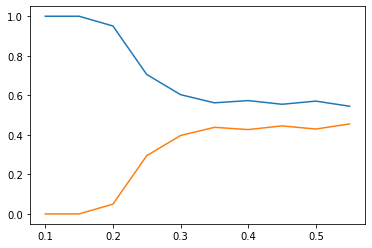

In [64]:
plt.plot(epsilons, conc0_eps)
plt.plot(epsilons, conc1_eps)

# Our modification

## Time to consensus

In [648]:
def extract_data_common(graph, opinion0_prob):
    G = nx.number_of_nodes(graph)
    nodes = list(graph.nodes())
    opinion0_count = int(opinion0_prob*G)
    opinions = [-1]*opinion0_count + [1]*(G - opinion0_count)
    random.shuffle(opinions)
    neighbors = [0]*G
    common = np.zeros((G, G))
    for i in range(G):
        neighbors[i] = list(graph.neighbors(nodes[i]))
    for i in range(G):
        for j in range(G):
            common[i][j] = len(set(neighbors[i]) & set(neighbors[j]))
    return opinions, neighbors, common

In [649]:
def sym_to_consensus_common(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    last_values = np.zeros(10000)
    opinions, neighbors, common = extract_data_common(graph, opinion0_prob)
    len_opinions = len(opinions)
    step = 0
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.sample(neighbors[chosen], k = q)
        chosen_opinions = np.array([opinions[i] for i in chosen_neighbors])
        chosen_common = [common[chosen, i] for i in chosen_neighbors]
        opposite_inds = np.where(chosen_opinions == -1*opinion)[0]
        opposite_opinion = np.sum([chosen_common[i] for i in opposite_inds]) / np.sum(chosen_common) \
            if np.sum(chosen_common) > 0 else 0
        
        if opposite_opinion > q0 or (epsilon > np.random.uniform() and opposite_opinion > 0):
            opinions[chosen] *= -1
        step += 1
        
    return step

In [650]:
def monte_carlo_sym_random_common(n, graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.erdos_renyi_graph(n, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(n, graph_prob)
        steps = sym_to_consensus_common(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [651]:
def monte_carlo_sym_barabasi_common(n, barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.barabasi_albert_graph(n, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        steps = sym_to_consensus_common(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                print((0, i))
                return 0
    return mean_step / MC_steps

In [652]:
def monte_carlo_sym_watts_common(n, watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps):
    mean_step = 0
    steps = 0
    counter = 0
    for i in range(MC_steps):
        g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.watts_strogatz_graph(n, watts_edges, watts_prob)
        steps += sym_to_consensus_common(g, opinion0_prob, q, q0, epsilon, max_steps)
        mean_step += steps
        if steps == max_steps:
            counter += 1
            if counter == 3:
                return 0
    return mean_step / MC_steps

In [653]:
def consensus_time_random_common(ns, graph_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**4):
    mean_times = np.zeros(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_random_common(ns[n], graph_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [654]:
def consensus_time_barabasi_common(ns, barabasi_edges, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**4):
    mean_times = np.zeros(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_barabasi_common(ns[n], barabasi_edges, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

In [655]:
def consensus_time_watts_common(ns, watts_edges, watts_prob, epsilon, MC_steps, opinion0_prob, q, q0, max_steps = 10**4):
    mean_times = np.zeros(len(ns))
    for n in range(len(ns)):
        print(ns[n])
        mean_times[n] = monte_carlo_sym_watts_common(ns[n], watts_edges, watts_prob, MC_steps, opinion0_prob, q, q0, epsilon, max_steps)
    return mean_times

## Magnetization

In [656]:
def sym_magnetization_common(graph, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    last_values = np.zeros(10000)
    opinions, neighbors, common = extract_data_common(graph, opinion0_prob)
    len_opinions = len(opinions)
    step = 0
    magnetization = np.zeros(max_steps)
    while len(list(set(opinions))) == 2 and step < max_steps:
        chosen = np.random.randint(0, len_opinions)
        opinion = opinions[chosen]
        chosen_neighbors = random.sample(neighbors[chosen], k = q)
        chosen_opinions = np.array([opinions[i] for i in chosen_neighbors])
        chosen_common = [common[chosen, i] for i in chosen_neighbors]
        opposite_inds = np.where(chosen_opinions == -1*opinion)[0]
        sum_chosen = np.sum(chosen_common)
        opposite_opinion = np.sum([chosen_common[i] for i in opposite_inds]) / sum_chosen \
            if sum_chosen > 0 else 0
        
        if opposite_opinion > q0 or (epsilon > np.random.uniform() and opposite_opinion > 0):
            opinions[chosen] *= -1
        magnetization[step] = np.sum(opinions)/len_opinions
        step += 1
    magnetization[step:] = magnetization[step - 1]
    return magnetization 

In [657]:
def avg_magnetization_common_random(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [658]:
def avg_magnetization_common_watts(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [659]:
def avg_magnetization_common_barabasi(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros((MCsteps, max_steps))
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps))
    return np.mean(results, axis = 0)

In [660]:
def avg_magnetization_common_random_last(N, graph_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.erdos_renyi_graph(N, graph_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.erdos_renyi_graph(N, graph_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [661]:
def avg_magnetization_common_watts_last(N, watts_edges, watts_prob, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        while min(dict(g.degree()).values()) < q:
            g = nx.watts_strogatz_graph(N, watts_edges, watts_prob)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [662]:
def avg_magnetization_common_barabasi_last(N, barabasi_edges, MCsteps, opinion0_prob, q, q0, epsilon, max_steps = 10**4):
    results = np.zeros(MCsteps)
    for i in range(MCsteps):
        g = nx.barabasi_albert_graph(N, barabasi_edges)
        while min(dict(g.degree()).values()) < q:
            g = nx.barabasi_albert_graph(N, barabasi_edges)
        results[i] = abs(sym_magnetization_common(g, opinion0_prob, q, q0, epsilon, max_steps)[-1])
    return np.mean(results)

In [ ]:
mag_barabasi = avg_magnetization_barabasi(N = 100, barabasi_edges = 6, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 4, epsilon = 0.1, max_steps = 10**4)

In [ ]:
mag_barabasi_common = avg_magnetization_common_barabasi(N = 100, barabasi_edges = 6, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 2/3, epsilon = 0.1, max_steps = 10**4)

In [ ]:
mag_watts = avg_magnetization_watts(N = 100, watts_edges = 11, watts_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 4, epsilon = 0.1, max_steps = 10**4)

In [ ]:
mag_watts_barabasi = avg_magnetization_common_watts(N = 100, watts_edges = 11, watts_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 2/3, epsilon = 0.1, max_steps = 10**4)

In [ ]:
mag_random = avg_magnetization_random(N = 100, graph_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 4, epsilon = 0.1, max_steps = 10**4)

In [ ]:
mag_random_common = avg_magnetization_common_random(N = 100, graph_prob = 0.5, MCsteps = 100, opinion0_prob = 0.5, q = 6, q0 = 2/3, epsilon = 0.1, max_steps = 10**4)

In [ ]:
plt.plot(mag_random[1:1000])
plt.plot(mag_random_common[1:1000])

In [ ]:
plt.plot(mag_watts[1:1000])
plt.plot(mag_watts_common[1:1000])

In [ ]:
plt.plot(mag_barabasi[1:1000])
plt.plot(mag_barabasi_common[1:1000])

In [72]:
ns = [100, 250, 500, 1000]
epsilons = np.arange(0.1, 0.3, 0.1)
q = 6
q0 = 2/3
MC_steps = 100
opinion0_prob = 0.5
barabasi_edges = 8

In [73]:
%%time
l = []
for e in epsilons:
    print(e)
    l.append(consensus_time_barabasi_common(ns, barabasi_edges, e, MC_steps, opinion0_prob, q, q0, max_steps = 10**4))

0.1
100
(0, 16)
250
(0, 5)
500


KeyboardInterrupt: 

In [78]:
barabasz1 = avg_magnetization_barabasi(100, 8, 100, 0.5, 6, 4, 0.1, max_steps = 10**4)

In [ ]:
barabasz2 = avg_magnetization_barabasi(100, 8, 100, 0.5, 6, 4, 0.1, max_steps = 10**4)